# Exercise 12: The nucleon-nucleon 2-point function

#### The nucleon-nucleon 2-point function data shared via email are divided in directories: each directory contains the 2-point function for a given gauge ensemble. The name of the directory contains information about the lattice size and the κ values for the Nf = 2 light sector (κud) and for the strange quark (κs). Additioanl information about the 16, 20 and 28 ensembles can be found in "https://www.jldg.org/ildg-data/CPPACS+JLQCDconfig.html". For the large volumes ensembles consult "http://www.jldg.org/ildg-data/PACSCSconfig.html".

#### Perform the following analysis using bootstrap (or jackknife) to evaluate statistical uncertainties:

 • Calculate the euclidean time dependence of each correlator and plot them.

 • Calculate the effective mass of each correlator as a function of Euclidean time and plot them.

 • Perform a constant fit where the effective mass plateaus and plot the extracted mass as a function of the pion mass and pion mass squared (pion masses can be found on the links above).
 
 • Plot the extracted mass from the previous analysis as a function of the lattice spacing squared (values of the lattice spacings can be found in the links above).

##### Exercise compiled by Prof. Andrea Shindler for the 2023 Summer School on Methods of Effective Field Theory and Lattice Field Theory @ Bad Honnef Physikzentrum.

##### Solution Notebook by Juan Fernandez

Availability of correlators data upon request: [personal email](mailto:juanfernandezdlg@gmail.com), [academic email](mailto:jfernande@ethz.ch)

# Part 2 of the solution: Analysis of all provided correlator sets

(For reference to how one set is analysed, consult part 1 of the solution)

In [1]:
# Required libraries
import csv
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import chisquare
import pyerrors as pe # The package has a repository with the implementation, documentation and more info in https://github.com/fjosw/pyerrors
# change widget to inline if problematic:
%matplotlib inline

# Pyerrors ref: Joswig, F., Kuberski, S., Kuhlmann, J. T., & Neuendorf, J. (2023). pyerrors: A python framework for error analysis of Monte Carlo data. Computer Physics Communications, 288, 108750. https://doi.org/10.1016/j.cpc.2023.108750

In [2]:
## These variables are NEEDED for the main analysis later on
# Listed here are the directories where the series are stored
corr_directories = [
    './TALENT_data/RC16x32_Kud01382500Ks01371000/CPEvenism64_jsm64_txt',
    './TALENT_data/RC16x32_Kud01382500Ks01371000/P15ism64_jsm64_txt',
    './TALENT_data/RC20x40_Kud01370000Ks01364000/CPEvenism64_jsm64_txt',
    './TALENT_data/RC28x56_Kud01356000Ks01351000/CPEvenism64_jsm64_txt',
    './TALENT_data/RC32x64_Kud01370000Ks01364000/CPEvenism64_jsm64_txt',
    './TALENT_data/RC32x64_Kud01372700Ks01364000/CPEvenism64_jsm64_txt',
    './TALENT_data/RC32x64_Kud01375400Ks01364000/CPEvenism64_jsm64_txt']

# Listed here are the series we want to analyse
corr_series = ['C2-1','C2-2','C2-3','C2-4','C2-a','C2-b']
corr_names = ['p000', 'p100', 'p110', 'p111', 'p200']


In [3]:
## Definition of functions for the analysis, this cell compiles the functions used in part 1 of the solution

# To process csv files of a single
def process_csv_files(directory, series):
    fileNames = sorted(filter(lambda x: x.startswith(series), filter(lambda x: os.path.isfile(os.path.join(directory, x)), os.listdir(directory)))) # OK: files sorted by name alphabetically

    data_arrays = {} # init data frame collection

    colnames = ['p000', 'p100', 'p110', 'p111', 'p200']
    ct = 0 # counter 
    for file in fileNames: # loop over files
        file_path = os.path.join(directory, file)
        data_arrays[ct] = pd.read_csv(file_path, na_filter= False,usecols=colnames) # TODO: The use of pandas might be bypassed
        data_arrays[ct]*=10**25 ## Rescale numbers to prevent underflow (empirical)
        ct += 1

    return data_arrays


# To create the observable class from the correlators dataframe TODO: This conversion from dataframe to obs class can be bypassed
def dataframe2ObsClass(df_collection, corrName):
    NS = len(df_collection) # number of samples
    NT = len(df_collection[0][corrName]) # number of time-slices
    peObs = [0]*NT
    listNames = [corrName]
    ## For each time slice
    for t in range(NT):
        listArrays = [np.zeros(NS)]
        for k in range(NS):
            listArrays[0][k] = df_collection[k][corrName][t]
        
        peObs[t] = pe.Obs(listArrays,listNames)
    
    return NT, NS, peObs


# To perform Jackknife on correlators' time series
def Obs2JackknifeTimeSeries(NT, NS, peObs):
    jackSamples = np.zeros([NT,NS+1])  # initialize lists
    for k in range(NT):
        jackSamples[k,:] = peObs[k].export_jackknife()  # obtain Jackknife samples for each time-slice with PyErrors
    return NT, NS, jackSamples


# To compute Jackknife Error from samples
def jackKnifeError(array):
    N = len(array)
    r = 0
    for k in range(N-1):
        r += (array[k+1] - array[0])**2
    return np.sqrt( ((N - 1)/N) * r )


# To compute Covariance matrix
def CovJ(array):
    # array is a NT x (NS+1) array
    NT,NS = np.shape(array)
    r = np.zeros([NT,NT])
    for k in range(NS-1):
        r += (array[:,k+1] - array[:,0]).reshape(NT,1) @ (array[:,k+1] - array[:,0]).reshape(1,NT)
    return r


# To compute Chi2 statistic
def chi2(avg, array, cov):
    return (avg - array) @ np.linalg.inv(cov) @ (avg - array).T


# To perform the Chi2 fit on the plateau region( given by [startIdx:endIdx] )
def chi2fit(array, cov, start, end):
    workArray = array[start:end]
    workCov = cov[start:end,start:end]
    ones = np.ones([1,len(workArray)])
    covinv = np.linalg.inv(workCov)
    return ((ones @ covinv @ workArray)/(ones @ covinv @ ones.T))[0,0] # [0,0] to 'convert' from 1x1 np array to scalar


# To perform Jackknife error estimation on the effective mass
def jackknifeEffMass(NT, NS, jackSamples):
    # NT,NS = jackSamples.shape()
    NS -= 1
    am_effJack = np.zeros([NT-1,NS+1]) # note: elem, [:,0] is the bare average
    am_effJack_Error = np.zeros(NT-1)

    for s in range(NS+1):
        for t in range(NT-1):
            # This should be possible with a np.vectorize and .diff upon re-factoring jackSamples into an np.array. For now this works OK:
            am_effJack[t,s] = np.log((jackSamples[t,s]) / (jackSamples[t+1,s])) 

    for t in range(NT-1):
        am_effJack_Error[t] = jackKnifeError(am_effJack[t,:])
    
    return am_effJack, am_effJack_Error


# To perform Jackknife error estimation on the correlator data
def jackknifeCorr(NT, NS, jackSamples):
    # NT,NS = jackSamples.shape()
    NS -= 1
    jackError = np.zeros(NT)

    for t in range(NT):
        jackError[t] = jackKnifeError(jackSamples[t,:])
    
    return jackSamples, jackError


# For plotting Jackknife effective mass to observe plateau
def plotJackknifeEffMass(corr_directory, corr_serie, corr_name):
    am_effJack, am_effJack_Error = jackknifeEffMass(*Obs2JackknifeTimeSeries(*dataframe2ObsClass(process_csv_files(corr_directory, corr_serie), corr_name)))
    fig = plt.figure()
    plt.errorbar(range(len(am_effJack_Error)),am_effJack[:,0], yerr=am_effJack_Error[:], label='Bare Average', capsize=3)
    plt.legend()
    plt.show()
    return am_effJack, fig


# For doing Jackknife error estimation on correlators and effective masses
def am_effANDcorrel_JK(corr_directory, corr_serie, corr_name):
    NT, NS, jackCorr = Obs2JackknifeTimeSeries(*dataframe2ObsClass(process_csv_files(corr_directory, corr_serie), corr_name))
    _, jackError = jackknifeCorr(NT, NS, jackCorr)
    am_effJack, am_effJack_Error = jackknifeEffMass(NT, NS, jackCorr)
    return jackCorr, jackError, am_effJack, am_effJack_Error


# For fitting on Plateau
def finalFit(am_effJack, startIdx, endIdx):
    NS = am_effJack.shape[1]
    NS += -1
    # Obtain Covariance matrix
    CovJtt = CovJ(am_effJack)
    # Obtain chi2 fits
    am_fit = np.zeros(NS+1)
    for k in range(NS+1):
        am_fit[k] = chi2fit(am_effJack[:,k], CovJtt, startIdx, endIdx)

    # Estimate fits error and bias-corrected estimates
    am_fit_biasCorrected = NS * am_fit[0] - (NS-1)*np.mean(am_fit[1:])
    am_fit_error = jackKnifeError(am_fit)

    return am_fit[0], am_fit_biasCorrected, am_fit_error


# To reset Data dictionary
def resetDataDict():
    return {
        'corr'         : 0,
        'corrError'    : 0, 
        'am_eff'       : 0, 
        'am_effError'  : 0,
        'massFit'      : 0, 
        'massBiasCorr' : 0,
        'massFitError' : 0    
    }


In [4]:
# TODO: In the future maybe change this dicts into another more convenient data struct

## Initialization of dicts to store analysed data
# To fill with time series / fits
dataDict = {
    'corr'         : 0,
    'corrError'    : 0, 
    'am_eff'       : 0, 
    'am_effError'  : 0,
    'massFit'      : 0,
    'massBiasCorr' : 0,
    'massFitError' : 0
}


# To be filled with corr_series[X] each with a dataDict
seriesDict = {} 


# Dict with data for each momentum choice p000, ....
pDict = {}


# MainDict with all processed info for a given directory. To be filled with corr_names[X] each with a seriesDict
mainDict = {}

In [5]:
# Here the plateau region is set from empirical observation => convenient to have ~[4:10] on all series
start_global = 4
end_global   = 10

for idx_dir, corr_directory in enumerate(corr_directories):
    pDict = {}
    for idx_corr, corr_name in enumerate(corr_names):
        seriesDict = {}
        for idx_series, corr_serie in enumerate(corr_series):
            dataDict = resetDataDict()

            try:
                corr, corrError, am_eff, am_effError = am_effANDcorrel_JK(corr_directory, corr_serie, corr_name)
                am_fit, am_biasCorrected, am_error   = finalFit(am_eff, start_global, end_global)
            except KeyError:
                # print('Error: ', e)
                continue

            dataDict['corr'        ] = corr[:,0]
            dataDict['corrError'   ] = corrError
            dataDict['am_eff'      ] = am_eff[:,0]
            dataDict['am_effError' ] = am_effError
            dataDict['massFit'     ] = am_fit
            dataDict['massBiasCorr'] = am_biasCorrected
            dataDict['massFitError'] = am_error

            seriesDict[corr_serie] = dataDict
        
        pDict[corr_name] = seriesDict

    mainDict.update({str(idx_dir) : pDict})


/var/folders/f6/w5y8k5qs5hbg2h_fz_3rvdnh0000gn/T/ipykernel_22747/2205855742.py:88: RuntimeWarning: invalid value encountered in log
  am_effJack[t,s] = np.log((jackSamples[t,s]) / (jackSamples[t+1,s]))
/var/folders/f6/w5y8k5qs5hbg2h_fz_3rvdnh0000gn/T/ipykernel_22747/2205855742.py:88: RuntimeWarning: invalid value encountered in log
  am_effJack[t,s] = np.log((jackSamples[t,s]) / (jackSamples[t+1,s]))
/var/folders/f6/w5y8k5qs5hbg2h_fz_3rvdnh0000gn/T/ipykernel_22747/2205855742.py:88: RuntimeWarning: invalid value encountered in log
  am_effJack[t,s] = np.log((jackSamples[t,s]) / (jackSamples[t+1,s]))
/var/folders/f6/w5y8k5qs5hbg2h_fz_3rvdnh0000gn/T/ipykernel_22747/2205855742.py:88: RuntimeWarning: invalid value encountered in log
  am_effJack[t,s] = np.log((jackSamples[t,s]) / (jackSamples[t+1,s]))
/var/folders/f6/w5y8k5qs5hbg2h_fz_3rvdnh0000gn/T/ipykernel_22747/2205855742.py:88: RuntimeWarning: invalid value encountered in log
  am_effJack[t,s] = np.log((jackSamples[t,s]) / (jackSamples

Now, the mainDict compiles all the analysed data, which can be addressed via 

`mainDict['SERIES_INDEX']['MOMENTUM_CHOICE']['SUB_SERIES_NAME']['DATA_ELEMENT']`

In [6]:
## This is the dictionary with the parameters for each of the configurations' ensembles
paramsDict = {
    'Series': ['0','1','2','3','4','5','6'],
    
    'Kud': ['0.1382500',
            '0.1382500',
            '0.1370000',
            '0.1356000',
            '0.1370000',
            '0.1372700',
            '0.1375400'],
    
    'Ks' : ['0.1371000',
            '0.1371000',
            '0.1364000',
            '0.1351000',
            '0.1364000',
            '0.1364000',
            '0.1364000'],
    
    'LatticeDims' : ['16x32',
                     '16x32',
                     '20x40',
                     '28x56',
                     '32x64',
                     '32x64',
                     '32x64'],

    'beta' : [1.83,1.83,1.90,2.05,
              1.90,1.90,1.90],

## For spacing, taking the K-input data
    'spacing_fm' : [0.1209,0.1209,0.0982,0.0685,  # from https://www.jldg.org/ildg-data/CPPACS+JLQCDconfig.html#SIMULATION
                    0.0907,0.0907,0.0907], # from https://www.jldg.org/ildg-data/PACSCSconfig.html#SIMULATION
    
    'spacing_error' : [0.0016,0.0016,0.0019,0.0026,
                       0.0013,0.0013,0.0013],

    'c_SW' : [1.7610,1.7610,1.7150,1.6280,
              1.715,1.715,1.715],

## Could not find all TODO: search in more refs.
    'm_pi' : [np.nan, np.nan,             # could not find
              0.32247,                    # from TABLE 5: https://arxiv.org/pdf/0807.1661.pdf
              np.nan,                     # could not find
              0.32242, 0.26191, 0.18903] # from TABLE 3: https://arxiv.org/pdf/0807.1661.pdf    
}

# Not used at the end:
# paramsDF = pd.DataFrame(paramsDict)

## Euclidean time dependence of correlator data

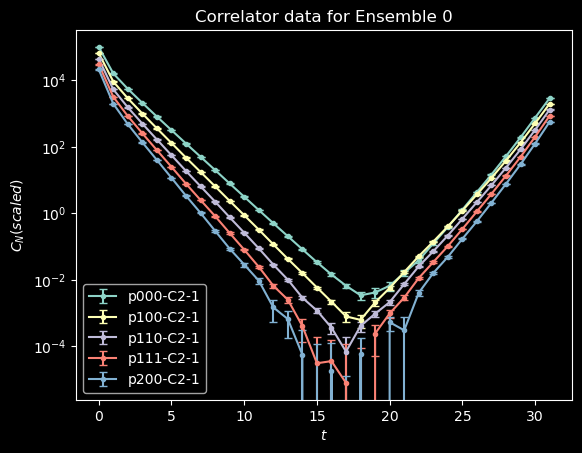

In [7]:
## Euclidean time dependence of correlator w/ errors estimate
ensemble2plot  = '0'                                   # Choose one from ['0','1','2','3','4','5','6'] 
momentums2plot = ['p000','p100','p110','p111','p200']  # Choose from ['p000','p100','p110','p111','p200']
series2plot    = ['C2-1']                       # Choose from ['C2-1','C2-2','C2-3','C2-4','C2-a','C2-b']

t = range(len(mainDict[ensemble2plot][momentums2plot[0]][series2plot[0]]['corr'])) # Time parameter

fig, ax = plt.subplots()
for i,ii in enumerate(momentums2plot):
    for j,jj in enumerate(series2plot):
        ax.errorbar(t, mainDict[ensemble2plot][ii][jj]['corr'], yerr=mainDict[ensemble2plot][ii][jj]['corrError'], label=ii+'-'+jj, fmt='.-', capsize=3)

ax.set_xlabel(r'$t$')
ax.set_ylabel(r'$C_N (scaled)$')
ax.set_title(r'Correlator data for Ensemble '+ensemble2plot)
ax.set_yscale('log')
ax.legend()
plt.show()


## Euclidean time dependence of effective masses

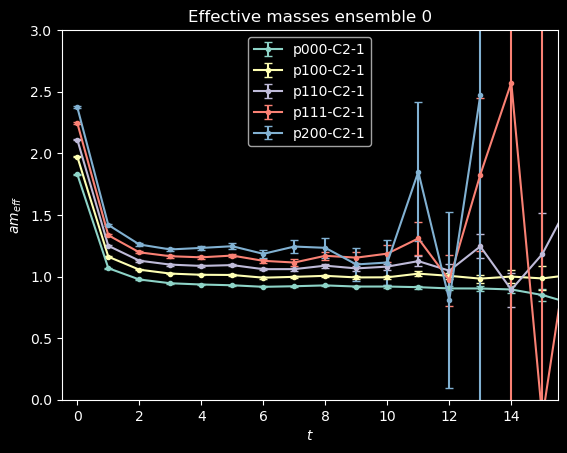

In [8]:
## Euclidean time dependence of am_eff w/ errors estimate
ensemble2plot  = '0'                                   # Choose one from ['0','1','2','3','4','5','6'] 
momentums2plot = ['p000','p100','p110','p111','p200']  # Choose from ['p000','p100','p110','p111','p200']
series2plot    = ['C2-1']                       # Choose from ['C2-1','C2-2','C2-3','C2-4','C2-a','C2-b']

t = range(len(mainDict[ensemble2plot][momentums2plot[0]][series2plot[0]]['am_eff'])) # Time parameter

fig, ax = plt.subplots()
for i,ii in enumerate(momentums2plot):
    for j,jj in enumerate(series2plot):
        ax.errorbar(t, mainDict[ensemble2plot][ii][jj]['am_eff'], yerr=mainDict[ensemble2plot][ii][jj]['am_effError'], label=ii+'-'+jj, fmt='.-', capsize=3)

ax.set_xlabel(r'$t$')
ax.set_ylabel(r'$am_{eff}$')
ax.set_title(r'Effective masses ensemble '+ensemble2plot)

# Limits for better visualization (comment to see broader am_eff+error)
ax.set_xlim(-0.5,15.5)
ax.set_ylim(0,3)

ax.legend()
plt.show()


## Plots of fitted masses vs lattice spacing:

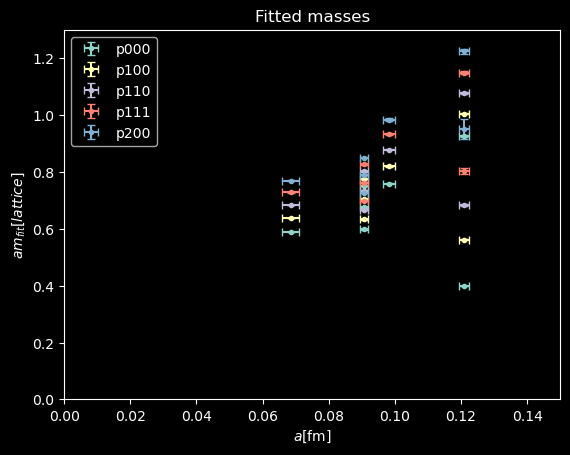

In [9]:
## Fitted Masses w/ errors estimate
ensemble2plot  = ['0','1','2','3','4','5','6']         # Choose from ['0','1','2','3','4','5','6'] 
momentums2plot = ['p000','p100','p110','p111','p200']  # Choose from ['p000','p100','p110','p111','p200']

# FOR ensembles 0,1,2,3: series2plot    = ['C2-1']
# FOR ensembles 4,5,6: series2plot    = ['C2-b']

a_data = np.zeros([len(ensemble2plot)    ,len(momentums2plot)])
aError_data = np.zeros([len(ensemble2plot) ,len(momentums2plot)])
am_data = np.zeros([len(ensemble2plot)   ,len(momentums2plot)])
amError_data = np.zeros([len(ensemble2plot),len(momentums2plot)])

for k,kk in enumerate(ensemble2plot):
    for i,ii in enumerate(momentums2plot):
        a_data[k,i] = paramsDict['spacing_fm'][k]
        aError_data[k,i] = paramsDict['spacing_error'][k]
        
        if k < 4:
            am_data[k,i] = mainDict[kk][ii]['C2-1']['massFit']
            amError_data[k,i] = mainDict[kk][ii]['C2-1']['massFitError']
        else:
            am_data[k,i] = mainDict[kk][ii]['C2-b']['massFit']
            amError_data[k,i] = mainDict[kk][ii]['C2-b']['massFitError']
        
fig, ax = plt.subplots()

for j,jj in enumerate(momentums2plot):
    ax.errorbar(a_data[:,j], am_data[:,j], xerr=aError_data[:,j], yerr=amError_data[:,j], fmt='.', label=jj, capsize=3)

ax.set_xlabel(r'$a$[fm]')
ax.set_ylabel(r'$am_{fit} [lattice]$')
ax.set_title(r'Fitted masses')

# For better visualization
ax.set_xlim(-0.0,.15)
ax.set_ylim(0,1.3)

ax.legend()
plt.show()


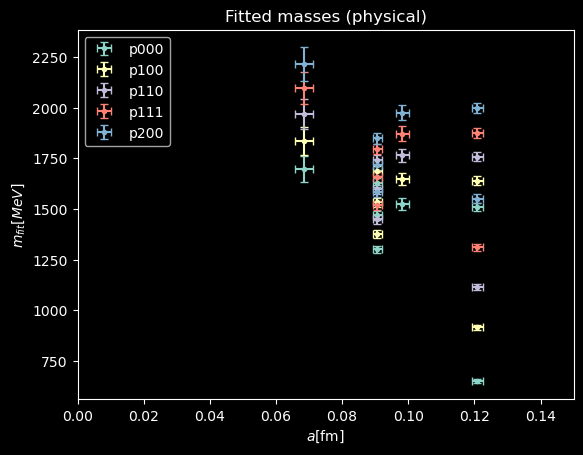

In [10]:
## Fitted Masses w/ errors estimate (physical units)
ensemble2plot  = ['0','1','2','3','4','5','6']         # Choose from ['0','1','2','3','4','5','6'] 
momentums2plot = ['p000','p100','p110','p111','p200']  # Choose from ['p000','p100','p110','p111','p200']

# FOR ensembles 0,1,2,3: series2plot    = ['C2-1']
# FOR ensembles 4,5,6: series2plot    = ['C2-b']

a_data = np.zeros([len(ensemble2plot)    ,len(momentums2plot)])
aError_data = np.zeros([len(ensemble2plot) ,len(momentums2plot)])
am_data = np.zeros([len(ensemble2plot)   ,len(momentums2plot)])
m_data = np.zeros([len(ensemble2plot)   ,len(momentums2plot)])
mError_data = np.zeros([len(ensemble2plot)   ,len(momentums2plot)])

for k,kk in enumerate(ensemble2plot):
    for i,ii in enumerate(momentums2plot):
        a_data[k,i] = paramsDict['spacing_fm'][k]
        aError_data[k,i] = paramsDict['spacing_error'][k]
        
        if k < 4:
            am_data[k,i] = mainDict[kk][ii]['C2-1']['massFit']
            amError_data[k,i] = mainDict[kk][ii]['C2-1']['massFitError']
        else:
            am_data[k,i] = mainDict[kk][ii]['C2-b']['massFit']
            amError_data[k,i] = mainDict[kk][ii]['C2-b']['massFitError']

# Physical masses [MeV]:        
m_data = 197.3*am_data/a_data
# Assume no am_fit errors (simple error prop + approx.)
mError_data = m_data * aError_data/a_data 

# Figure
fig, ax = plt.subplots()
for j,jj in enumerate(momentums2plot):
    ax.errorbar(a_data[:,j], m_data[:,j], xerr=aError_data[:,j], yerr=mError_data[:,j], fmt='.', label=jj, capsize=3)

ax.set_xlabel(r'$a$[fm]')
ax.set_ylabel(r'$m_{fit} [MeV]$')
ax.set_title(r'Fitted masses (physical)')

# For better visualization
ax.set_xlim(-0.0,.15)

ax.legend()
plt.show()


## ... More plots can be made below by relating relevant arrays in the mainDict with the paramsDict from above...